The majority of this code is from the examples of https://github.com/opengeos/segment-geospatial, e.g., 
- https://samgeo.gishub.org/examples/text_prompts/
- https://samgeo.gishub.org/examples/input_prompts/ 

# Step 1: Bridge Segmentation in Munich
I'll first try to apply the technique to the Maximiliansbrücke bridge in Munich. I'll use both the text prompt and the picker and also look at generated masks.

In [3]:
# %pip install segment-geospatial leafmap localtileserver groundingdino-py 

In [2]:
import os
import leafmap
from samgeo import SamGeo, tms_to_geotiff

## Selecting Area

In [3]:
m = leafmap.Map(center=[48.1370199,11.5908739], zoom=17, height="800px")
m.add_basemap("SATELLITE")
m

Map(center=[48.1370199, 11.5908739], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title…

In [4]:
if m.user_roi is not None:
    bbox = m.user_roi_bounds()
else:
    bbox = [11.5845, 48.1325, 11.5983, 48.1399]


In [5]:
image = "satellite.tif"
tms_to_geotiff(output=image, bbox=bbox, zoom=16, source="Satellite", overwrite=True)

Downloaded image 01/12
Downloaded image 02/12
Downloaded image 03/12
Downloaded image 04/12
Downloaded image 05/12
Downloaded image 06/12
Downloaded image 07/12
Downloaded image 08/12
Downloaded image 09/12
Downloaded image 10/12
Downloaded image 11/12
Downloaded image 12/12
Saving GeoTIFF. Please wait...
Image saved to satellite.tif


In [6]:
m.layers[-1].visible = False
m.add_raster(image, layer_name="Image")
m

Map(bottom=11645293.0, center=[48.1370199, 11.5908739], controls=(ZoomControl(options=['position', 'zoom_in_te…

## Generate Masks on image

In [7]:
sam = SamGeo(
    model_type="vit_h",
    checkpoint='sam_vit_h_4b8939.pth',
    sam_kwargs=None,
)


In [8]:
sam.generate(image, output="masks.tif", foreground=True, unique=True)


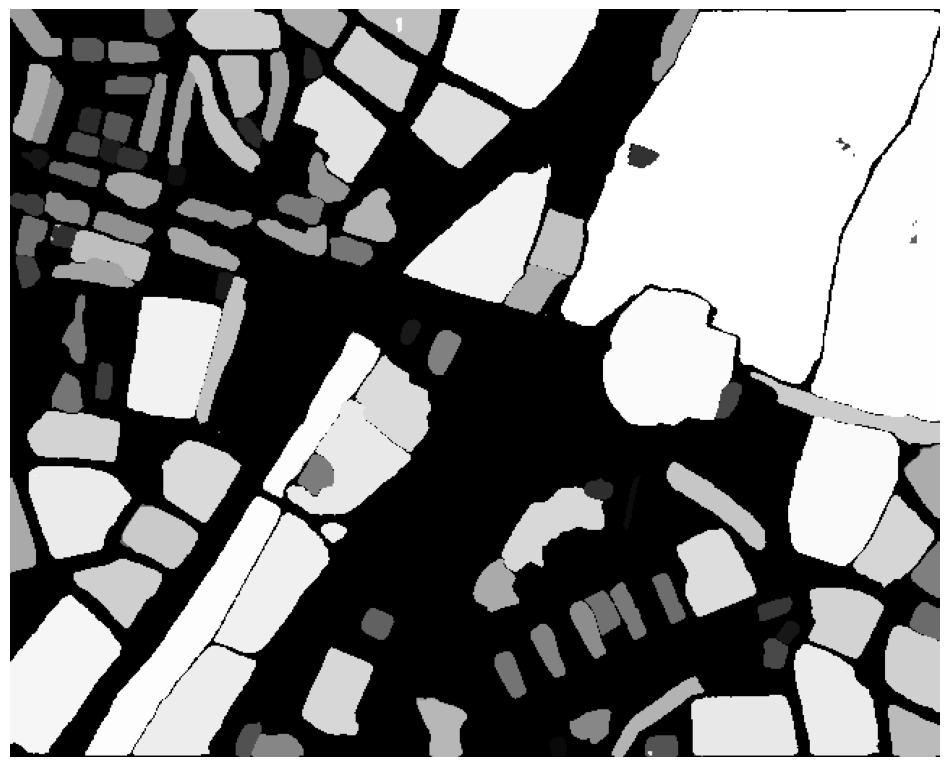

In [9]:
sam.show_masks(cmap="binary_r")


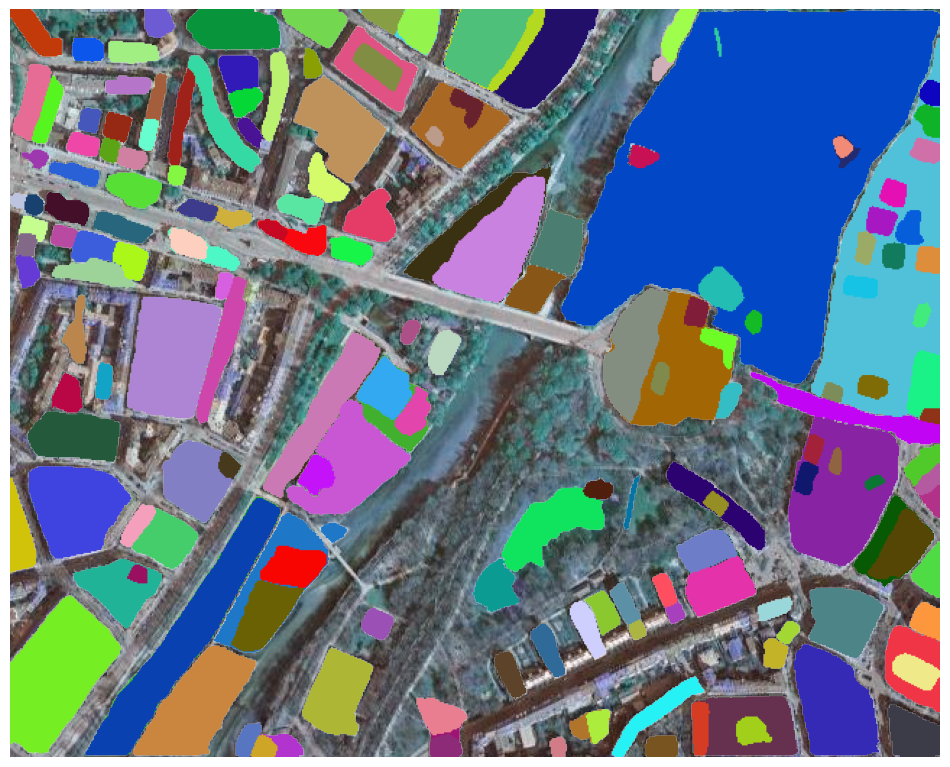

In [10]:
sam.show_anns(axis="off", alpha=1, output="annotations.tif")



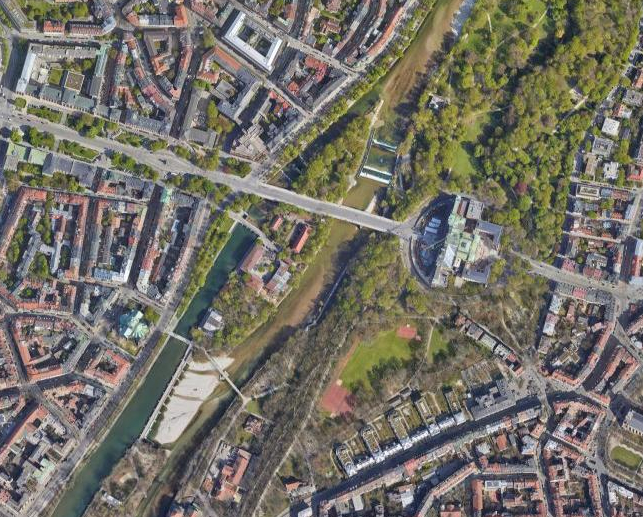
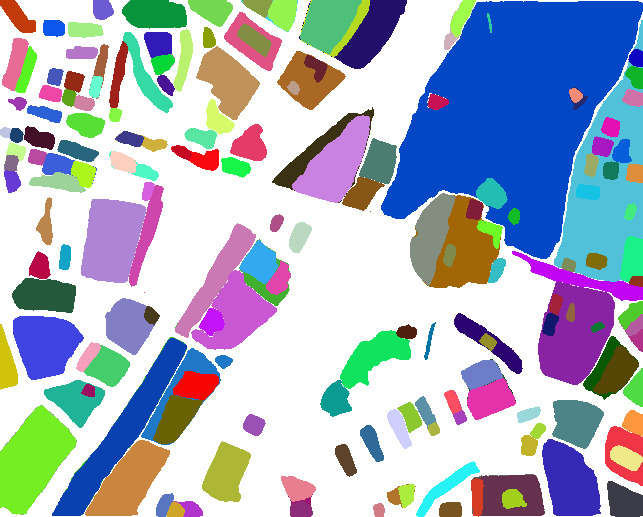

In [11]:
leafmap.image_comparison(
    "satellite.tif",
    "annotations.tif",
    label1="Satellite Image",
    label2="Image Segmentation",
)


We can see that the model does not capture bridges but for example waterways

## Using the prediction mode of Sam

In [12]:
sam = SamGeo(
    model_type="vit_h",
    checkpoint="sam_vit_h_4b8939.pth",
    automatic=False,
    sam_kwargs=None,
)

In [13]:
sam.set_image(image)

In [14]:
m = sam.show_map()
m

Map(center=[20, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

Generating segmentation for the bridges works reasonably wekk with the picker if we also select strees and rivers as background classes, else it would just yield the entire street instead of the bridge
## Using Text prompt for SAM

In [15]:
from samgeo.text_sam import LangSAM


In [16]:
sam = LangSAM()


final text_encoder_type: bert-base-uncased


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [17]:
text_prompt = "bridge"


In [18]:
sam.predict(image, text_prompt, box_threshold=0.24, text_threshold=0.24)


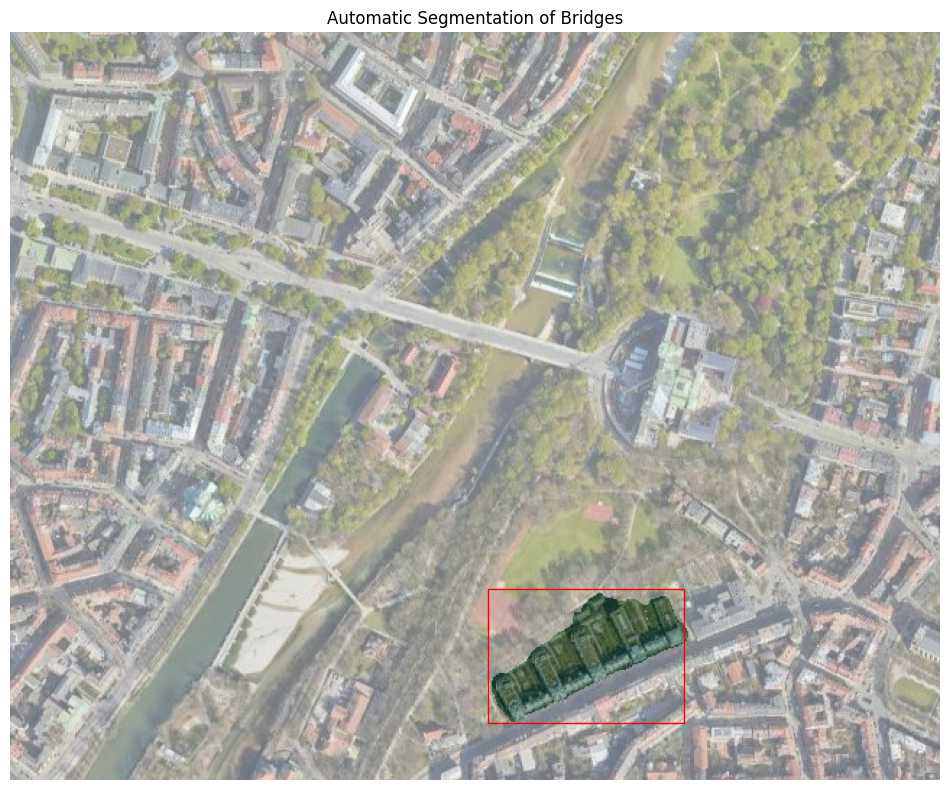

In [19]:
sam.show_anns(
    cmap='Greens',
    box_color='red',
    title='Automatic Segmentation of Bridges',
    blend=True,
)

Clearly the text encoding didn't yield the expected results out of the box

In [20]:
sam.show_map()

Map(center=[20, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

Even the tree classifier is not very reliable, requires a lot of finetuning of parameters and even then several trees are not considered

# Step 2: Reproducing the original results

Since my results are so much worse than what I've seen in the documentation, I want to make sure that everything is set up correctly. I can check by reproducing exactly the same results as in the documentation / example below

In [21]:
bbox = [-51.2565, -22.1777, -51.2512, -22.175]
image = "Image.tif"
tms_to_geotiff(output=image, bbox=bbox, zoom=19, source="Satellite", overwrite=True)

m.layers[-1].visible = False
m.add_raster(image, layer_name="Image")
m

Downloaded image 01/45
Downloaded image 02/45
Downloaded image 03/45
Downloaded image 04/45
Downloaded image 05/45
Downloaded image 06/45
Downloaded image 07/45
Downloaded image 08/45
Downloaded image 09/45
Downloaded image 10/45
Downloaded image 11/45
Downloaded image 12/45
Downloaded image 13/45
Downloaded image 14/45
Downloaded image 15/45
Downloaded image 16/45
Downloaded image 17/45
Downloaded image 18/45
Downloaded image 19/45
Downloaded image 20/45
Downloaded image 21/45
Downloaded image 22/45
Downloaded image 23/45
Downloaded image 24/45
Downloaded image 25/45
Downloaded image 26/45
Downloaded image 27/45
Downloaded image 28/45
Downloaded image 29/45
Downloaded image 30/45
Downloaded image 31/45
Downloaded image 32/45
Downloaded image 33/45
Downloaded image 34/45
Downloaded image 35/45
Downloaded image 36/45
Downloaded image 37/45
Downloaded image 38/45
Downloaded image 39/45
Downloaded image 40/45
Downloaded image 41/45
Downloaded image 42/45
Downloaded image 43/45
Downloaded 

Map(bottom=11645272.0, center=[48.13644940386344, 11.592504543012174], controls=(ZoomControl(options=['positio…

In [22]:
text_prompt = "tree"

In [23]:
sam.predict(image, text_prompt, box_threshold=0.24, text_threshold=0.24)


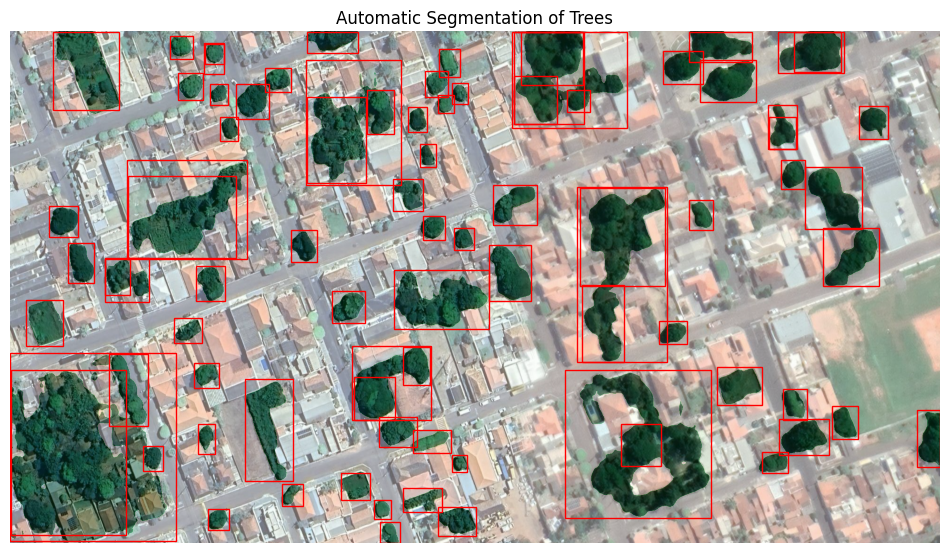

In [24]:
sam.show_anns(
    cmap='Greens',
    box_color='red',
    title='Automatic Segmentation of Trees',
    blend=True,
)

Ok. This is clearly the same output as we've seen in the documentation. On second sight, the model also doesn't find all trees in this area (and segments grass as trees in some cases). So, we can conclude that above the setup was working in general, but the technique or model is not yielding sufficient results

## Where to go from here?
Next, we need to understand both the paper and the tooling in more detail to make sure we don't miss anything crucial (like setting correct parameters or doing data preprocessing). Also, we need to check whether and how finetuning can be done on the data